# Quickstart

## Preliminaries

### Imports

In [16]:
import mercs
import numpy as np
from mercs.tests import load_iris, default_dataset
from mercs.core import Mercs

import pandas as pd

## Fit

Here a small MERCS testdrive for what I suppose you'll need. First, let us generate a basic dataset. Some utility-functions are integrated in MERCS so that goes like this

In [17]:
train, test = default_dataset(n_features=10)

df = pd.DataFrame(train)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.675737,-0.476428,3.581450,0.183020,-1.777475,0.136767,1.160297,0.129889,1.260818,-1.564195,0.0
1,1.173828,0.633868,1.371909,-1.326919,1.293080,1.524197,1.310965,-3.103991,-0.214067,1.064141,1.0
2,-5.643059,1.305686,4.253110,-2.597300,3.752776,-0.800193,1.173064,0.926055,-3.926815,-4.166201,0.0
3,0.649619,1.774041,1.844340,1.939269,2.874112,1.844517,-1.189195,-1.955451,-3.466255,3.035215,1.0
4,-0.839893,-1.723207,-0.679333,2.020422,-1.034357,0.416687,1.367039,0.497800,-1.313362,-0.440382,1.0


In [18]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.466173,0.001240,0.624970,-0.005191,0.450649,0.038921,-0.455200,0.072851,-0.472249,-0.418480,0.491250
std,2.036365,2.150285,2.168501,2.086619,1.953769,2.099301,2.078551,2.014238,1.898000,2.052702,0.500236
min,-7.455322,-6.817417,-6.925613,-7.030162,-5.708949,-6.865339,-7.238353,-6.184692,-6.159434,-8.705917,0.000000
25%,-0.954399,-1.509110,-0.816581,-1.380624,-0.691509,-1.329481,-1.756418,-1.224983,-1.703273,-1.797529,0.000000
50%,0.451760,0.075555,0.674027,0.118554,0.547505,0.108292,-0.493528,0.174550,-0.568166,-0.292757,0.000000
75%,1.847537,1.384226,2.148864,1.398455,1.820179,1.454181,0.836809,1.497582,0.712452,1.053721,1.000000
max,6.365330,7.601766,6.390253,8.237993,7.501492,7.021821,6.489389,6.832418,6.903293,5.101133,1.000000


Now let's train a MERCS model. To know what options you have, come talk to me or dig in the code. For induction, `nb_targets` and `nb_iterations` matter most. Number of targets speaks for itself, number of iterations manages the amount of trees _for each target_. With `n_jobs` you can do multi-core learning (with joblib, really basic, but works fine on single machine), that makes stuff faster. `fraction_missing` sets the amount of attributes that is missing for a tree. However, this parameter only has an effect if you use the `random` selection algorithm. The alternative is the `base` algorithm, which selects targets, and uses all the rest as input.

In [19]:
clf = Mercs(
    max_depth=4,
    selection_algorithm="random",
    fraction_missing=0.6,
    nb_targets=2,
    nb_iterations=2,
    n_jobs=8,
    verbose=1,
    inference_algorithm="own",
    max_steps=8,
    prediction_algorithm="it",
)

You have to specify the nominal attributes yourself. This determines whether a regressor or a classifier is learned for that target. MERCS takes care of grouping targets such that no mixed sets are created.

In [20]:
nominal_ids = {train.shape[1]-1}
nominal_ids

{10}

In [21]:
clf.fit(train, nominal_attributes=nominal_ids)

/cw/dtaijupiter/NoCsBack/dtai/elia/mercs/src/mercs/algo/induction.py:191: UserWarning: Training is being parallellized using Joblib. Number of jobs = 8
  warnings.warn(msg)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    3.2s finished
/cw/dtaijupiter/NoCsBack/dtai/elia/miniconda/envs/rwrf/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So, now we have learned trees with two targets, but only a single target was nominal. If MERCS worked well, it should have learned single-target classifiers (for attribute 4) and multi-target regressors for all other target sets.

In [22]:
for idx, m in enumerate(clf.m_list):
    msg = """
    Model with index: {}
    {}
    """.format(idx, m.model)
    print(msg)


    Model with index: 0
    DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=121958, splitter='best')
    

    Model with index: 1
    DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=671155, splitter='best')
    

    Model with index: 2
    DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      ma

So, that looks good already. Let's examine up close.

In [23]:
clf.m_codes

array([[-1,  0,  0, -1, -1, -1, -1,  0,  0,  0,  1],
       [ 0,  0, -1, -1, -1, -1, -1, -1, -1,  0,  1],
       [-1, -1,  0, -1, -1, -1, -1,  1, -1,  1, -1],
       [-1, -1, -1,  1,  1,  0,  0, -1,  0, -1, -1],
       [-1,  1,  1, -1,  0, -1, -1, -1, -1,  0, -1],
       [ 0,  0, -1, -1,  0,  1,  0,  0,  1, -1, -1],
       [ 1,  0, -1, -1, -1, -1,  1,  0,  0, -1, -1],
       [-1,  1,  1, -1, -1, -1, -1,  0,  0,  0,  0],
       [ 0, -1,  0, -1,  0,  1, -1, -1, -1,  1,  0],
       [ 1, -1, -1, -1, -1, -1,  1,  0, -1, -1,  0],
       [-1,  0,  0, -1,  1, -1, -1, -1,  1, -1, -1],
       [-1,  0, -1,  1, -1,  0, -1,  1,  0, -1,  0]])

That's the matrix that summarizes everything. This can be dense to parse, and there's alternatives to gain insights, for instance;

In [24]:
for m_idx, m in enumerate(clf.m_list):
    msg = """
    Tree with id:          {}
    has source attributes: {}
    has target attributes: {},
    and predicts {} attributes
    """.format(m_idx, m.desc_ids, m.targ_ids, m.out_kind)
    print(msg)


    Tree with id:          0
    has source attributes: [1, 2, 7, 8, 9]
    has target attributes: [10],
    and predicts nominal attributes
    

    Tree with id:          1
    has source attributes: [0, 1, 9]
    has target attributes: [10],
    and predicts nominal attributes
    

    Tree with id:          2
    has source attributes: [2]
    has target attributes: [7, 9],
    and predicts numeric attributes
    

    Tree with id:          3
    has source attributes: [5, 6, 8]
    has target attributes: [3, 4],
    and predicts numeric attributes
    

    Tree with id:          4
    has source attributes: [4, 9]
    has target attributes: [1, 2],
    and predicts numeric attributes
    

    Tree with id:          5
    has source attributes: [0, 1, 4, 6, 7]
    has target attributes: [5, 8],
    and predicts numeric attributes
    

    Tree with id:          6
    has source attributes: [1, 7, 8]
    has target attributes: [0, 6],
    and predicts numeric attributes
    


And that concludes my quick tour of how to fit with MERCS.

## Prediction

First, we generate a query.

In [25]:
# Single target
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-1:] = 1
print("Query code is: {}".format(q_code))

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

Query code is: [0 0 0 0 0 0 0 0 0 0 1]


array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])

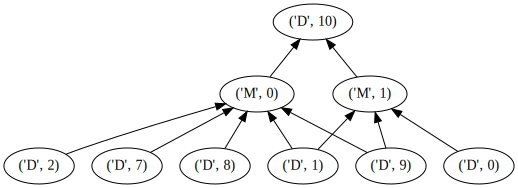

In [26]:
clf.show_q_diagram()

In [27]:
# Multi-target
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-2:] = 1
print("Query code is: {}".format(q_code))

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

Query code is: [0 0 0 0 0 0 0 0 0 1 1]


array([[ 0.8987434 ,  1.        ],
       [-0.35476461,  0.        ],
       [-0.35476461,  1.        ],
       [-0.35476461,  0.        ],
       [-0.6409689 ,  1.        ],
       [-0.6409689 ,  1.        ],
       [-1.70072951,  0.        ],
       [-0.35476461,  1.        ],
       [-0.6409689 ,  1.        ],
       [-0.35476461,  0.        ]])

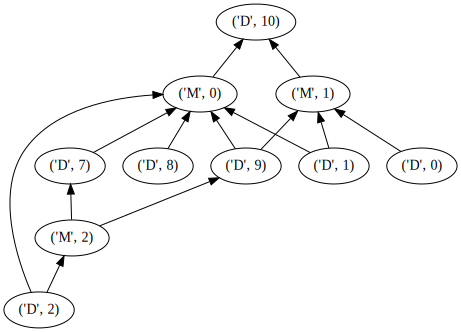

In [28]:
clf.show_q_diagram()

In [31]:
# Missing attributes
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-1:] = 1
q_code[:5] = -1
print("Query code is: {}".format(q_code))

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

Query code is: [-1 -1 -1 -1 -1  0  0  0  0  0  1]


array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])

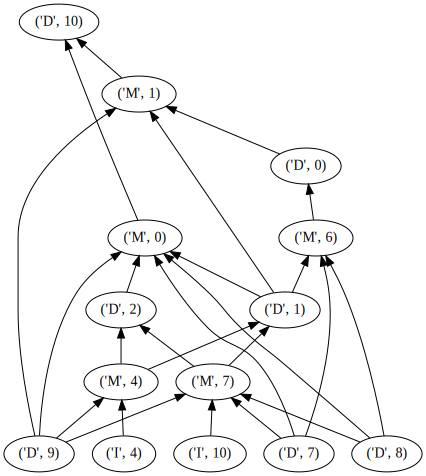

In [32]:
clf.show_q_diagram()